# Liesel-GAM Demo Notebook

## Setup and Imports

In [9]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [10]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

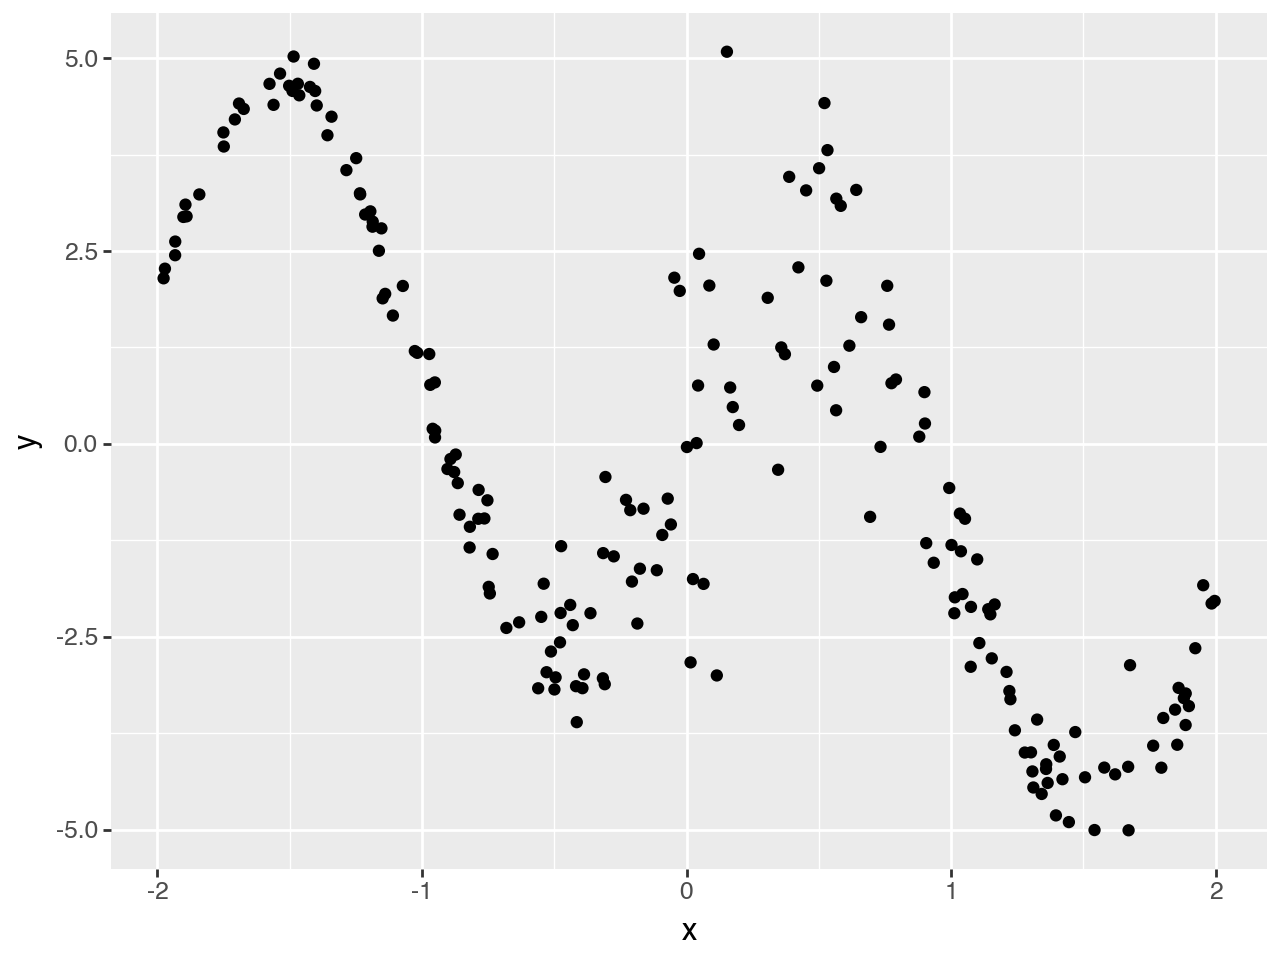

In [11]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [12]:
loc = gam.AdditivePredictor("loc")
scale = gam.AdditivePredictor("scale", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)


registry = gam.PandasRegistry(df)
tbl = gam.TermBuilder(registry, prefix_names_by="loc.")
tbs = gam.TermBuilder(registry, prefix_names_by="scale.")

loc += tbl.ps("x", k=20)
scale += tbs.ps("x", k=20)

### Build and plot model

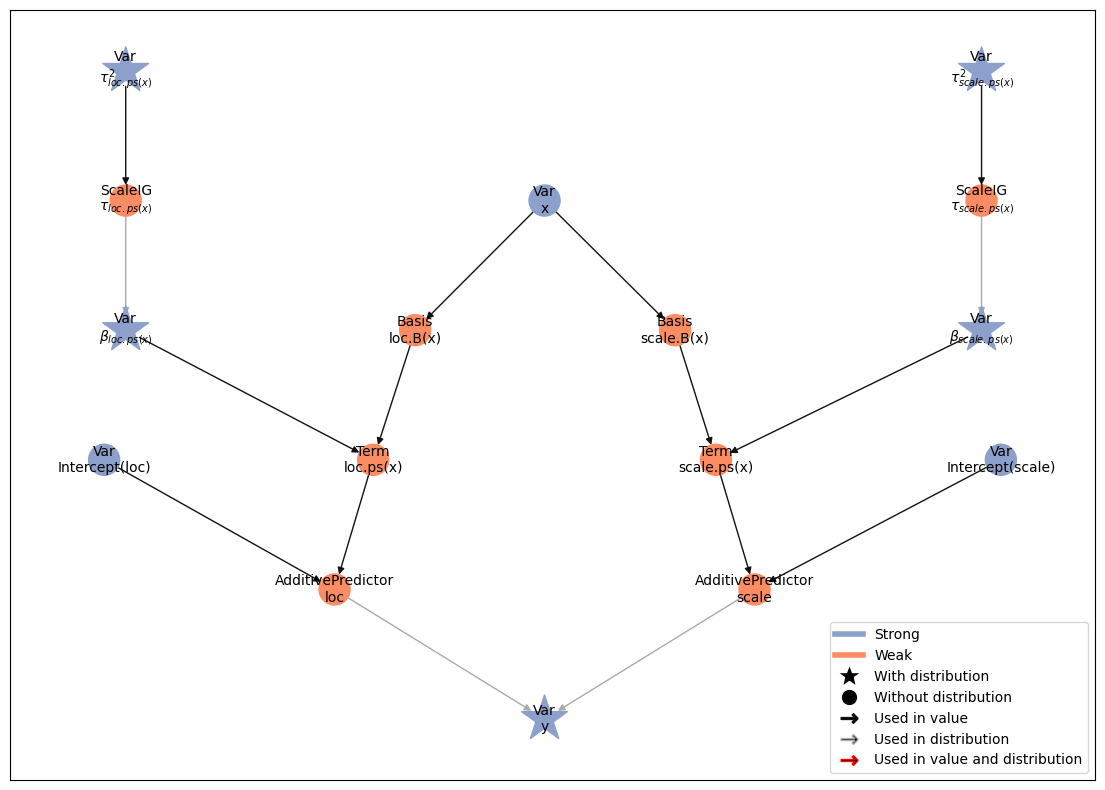

In [13]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'Intercept(scale)', '$\\beta_{scale.ps(x)}$', '$\\tau^2_{scale.ps(x)}$', 'Intercept(loc)', '$\\beta_{loc.ps(x)}$', '$\\tau^2_{loc.ps(x)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.65chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1071.62chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1457.62chunk/s]
liesel.goose.engin

### MCMC summary

In [15]:
summary = gs.Summary(results)
summary

Parameter summary:

                                 kernel      mean        sd    q_0.05  \
parameter              index                                            
$\beta_{loc.ps(x)}$    (0,)   kernel_04  0.157605  0.336731 -0.384628   
                       (1,)   kernel_04 -0.140719  0.307135 -0.659497   
                       (2,)   kernel_04  0.129901  0.294514 -0.343879   
                       (3,)   kernel_04  0.135902  0.294965 -0.346493   
                       (4,)   kernel_04 -0.261661  0.282876 -0.725451   
                       (5,)   kernel_04  0.024961  0.261803 -0.398580   
                       (6,)   kernel_04  0.013779  0.252114 -0.389601   
                       (7,)   kernel_04  0.129337  0.230625 -0.239853   
                       (8,)   kernel_04  0.066197  0.220649 -0.290164   
                       (9,)   kernel_04  0.072408  0.182705 -0.225638   
                       (10,)  kernel_04  0.082483  0.167602 -0.205627   
                       (11,)  kernel_04 -0.050976  0.136848 -0.278596   
                       (12,)  kernel_04  0.069129  0.114144 -0.116741   
                       (13,)  kernel_04 -0.080863  0.086556 -0.222483   
                       (14,)  kernel_04  1.231715  0.063407  1.128956   
                       (15,)  kernel_04  0.024628  0.041598 -0.042417   
                       (16,)  kernel_04 -0.016115  0.021388 -0.050633   
                       (17,)  kernel_04  0.010035  0.008934 -0.004301   
                       (18,)  kernel_04 -0.422390  0.030804 -0.472488   
$\beta_{scale.ps(x)}$  (0,)   kernel_01  0.011320  0.077311 -0.110540   
                       (1,)   kernel_01 -0.009645  0.076785 -0.139870   
                       (2,)   kernel_01 -0.010359  0.075400 -0.135310   
                       (3,)   kernel_01 -0.003398  0.074631 -0.122603   
                       (4,)   kernel_01  0.002656  0.074626 -0.117122   
                       (5,)   kernel_01 -0.004059  0.074807 -0.126093   
                       (6,)   kernel_01  0.025637  0.076507 -0.090603   
                       (7,)   kernel_01  0.031194  0.073276 -0.083491   
                       (8,)   kernel_01  0.011334  0.072532 -0.103154   
                       (9,)   kernel_01 -0.012586  0.070031 -0.129943   
                       (10,)  kernel_01  0.013942  0.068452 -0.093324   
                       (11,)  kernel_01  0.008157  0.062166 -0.093125   
                       (12,)  kernel_01  0.066559  0.061491 -0.027647   
                       (13,)  kernel_01 -0.065450  0.050675 -0.152619   
                       (14,)  kernel_01  0.059661  0.041352 -0.006558   
                       (15,)  kernel_01  0.079156  0.028635  0.033101   
                       (16,)  kernel_01  0.004782  0.016789 -0.022611   
                       (17,)  kernel_01 -0.041946  0.007056 -0.053090   
                       (18,)  kernel_01  0.129514  0.027234  0.083561   
$\tau^2_{loc.ps(x)}$   ()     kernel_05  0.139723  0.059808  0.070972   
$\tau^2_{scale.ps(x)}$ ()     kernel_02  0.005941  0.004227  0.001996   
Intercept(loc)         ()     kernel_03 -0.322242  0.057534 -0.417256   
Intercept(scale)       ()     kernel_00 -0.627426  0.052725 -0.714383   

                                 q_0.5    q_0.95  sample_size     ess_bulk  \
parameter              index                                                 
$\beta_{loc.ps(x)}$    (0,)   0.150207  0.721851         4000  3336.908620   
                       (1,)  -0.129651  0.347464         4000  3552.288717   
                       (2,)   0.119855  0.630512         4000  3242.823943   
                       (3,)   0.135171  0.630155         4000  3531.278865   
                       (4,)  -0.255551  0.200984         4000  3626.163595   
                       (5,)   0.024079  0.448330         4000  3491.322506   
                       (6,)   0.009998  0.425673         4000  3340.571829   
                       (7,)   0.126571  0.512165         4000  34

### MCMC trace plots

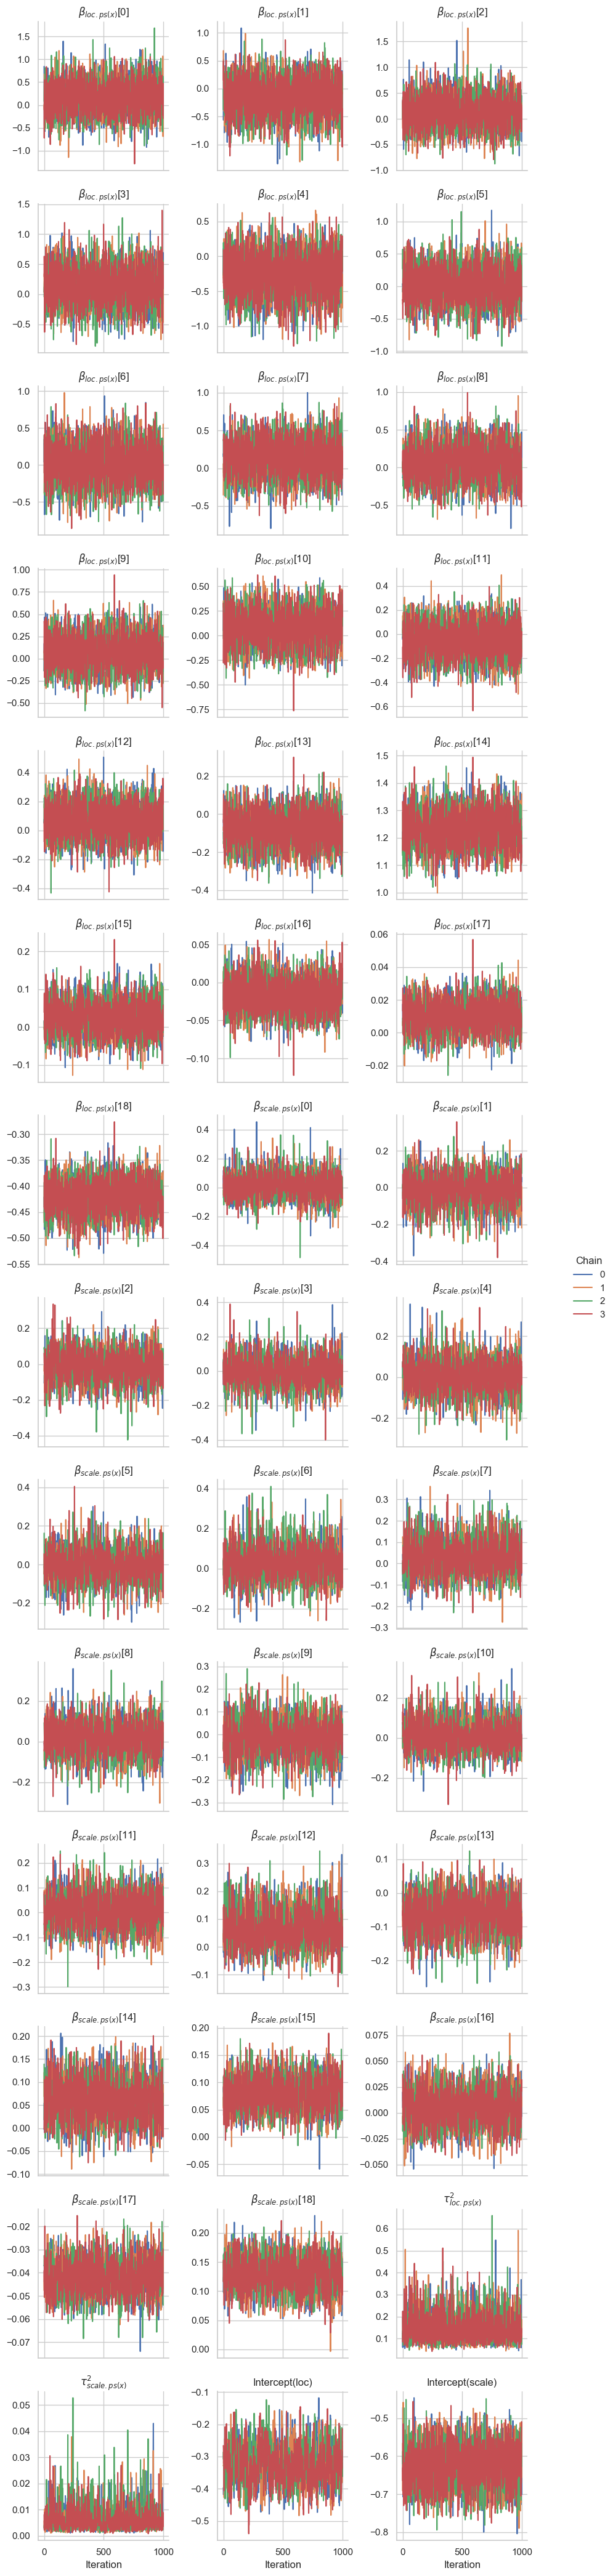

In [16]:
gs.plot_trace(results)

## Predictions

In [17]:
samples = results.get_posterior_samples()

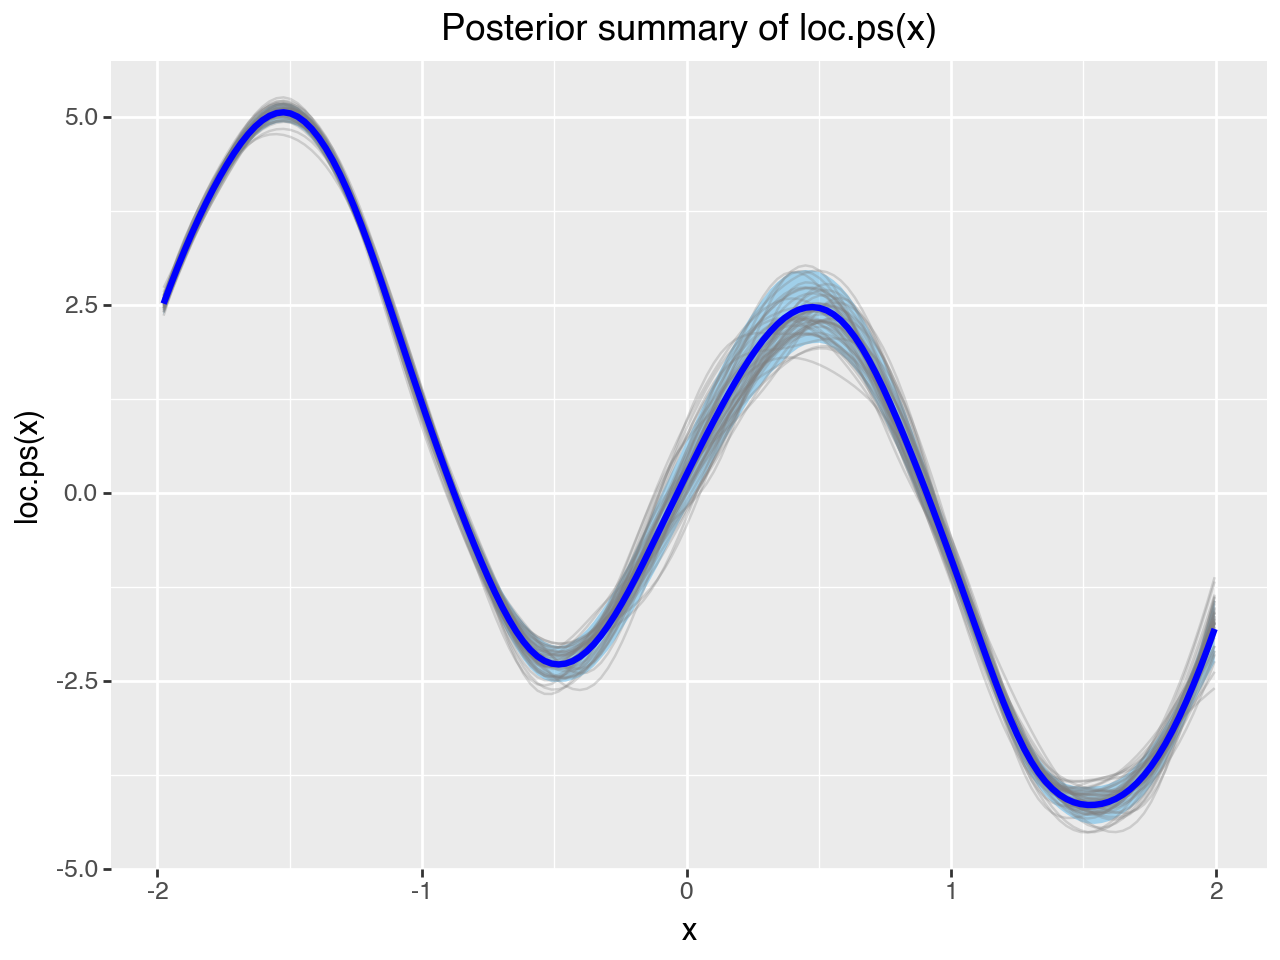

In [18]:
gam.plot_1d_smooth(term=model.vars["loc.ps(x)"], samples=samples)

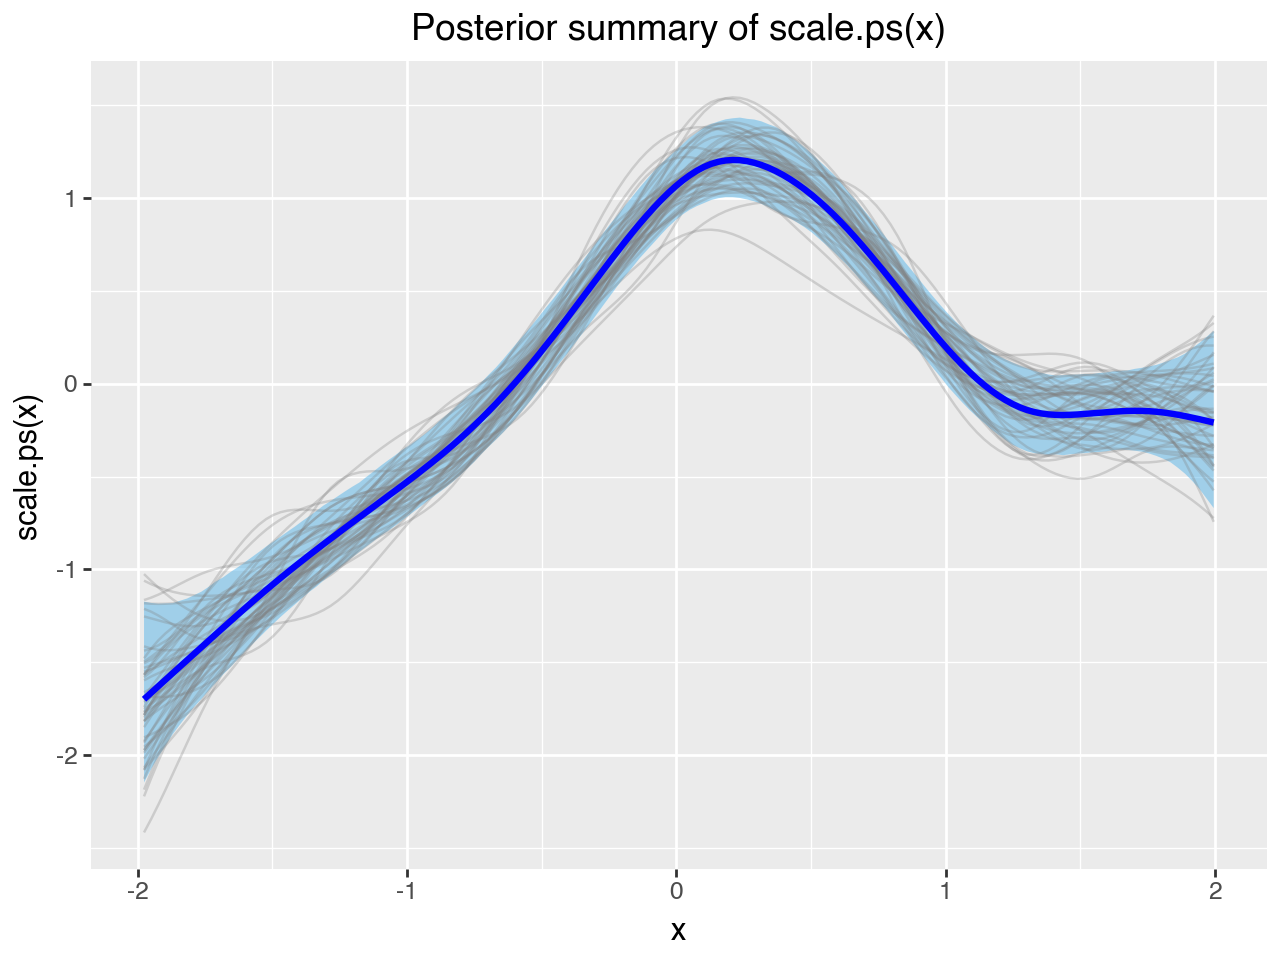

In [19]:
gam.plot_1d_smooth(term=model.vars["scale.ps(x)"], samples=samples)